In [31]:
import pandas as pd

X_unfiltered = pd.read_csv('../X_train.csv')
y = pd.read_csv('../y_train.csv')
y = y.values.ravel()
X_test1 = pd.read_csv('../X_test_1.csv')
X_test2 = pd.read_csv('../X_test_2.csv')
y_test_2 = pd.read_csv('../y_test_2_reduced.csv')
y_test_2 = y_test_2.values.ravel()


In [3]:
# Check for missing values
missing = X_unfiltered.isnull().sum()
missing = missing[missing > 0]
print(missing)

#no missing values

Series([], dtype: int64)


In [64]:
# optional -> Used if needed for model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unfiltered)
X_test_scaled = scaler.transform(X_test1)



In [8]:
class_counts = pd.Series(y).value_counts().sort_index()
print("Class counts:\n", class_counts)


Class counts:
 0       18
1        7
2        7
3       65
4      238
5     4479
6      553
7      103
8      516
9       25
10    1081
11      78
12     457
13      62
14     264
15      26
16       6
17     354
18      60
19     177
20     153
21     269
22       7
23      41
24     385
25     184
26     278
27     107
Name: count, dtype: int64


In [9]:
class_percentages = pd.Series(y).value_counts(normalize=True).sort_index() * 100
print("Class percentages:\n", class_percentages)

Class percentages:
 0      0.18
1      0.07
2      0.07
3      0.65
4      2.38
5     44.79
6      5.53
7      1.03
8      5.16
9      0.25
10    10.81
11     0.78
12     4.57
13     0.62
14     2.64
15     0.26
16     0.06
17     3.54
18     0.60
19     1.77
20     1.53
21     2.69
22     0.07
23     0.41
24     3.85
25     1.84
26     2.78
27     1.07
Name: proportion, dtype: float64


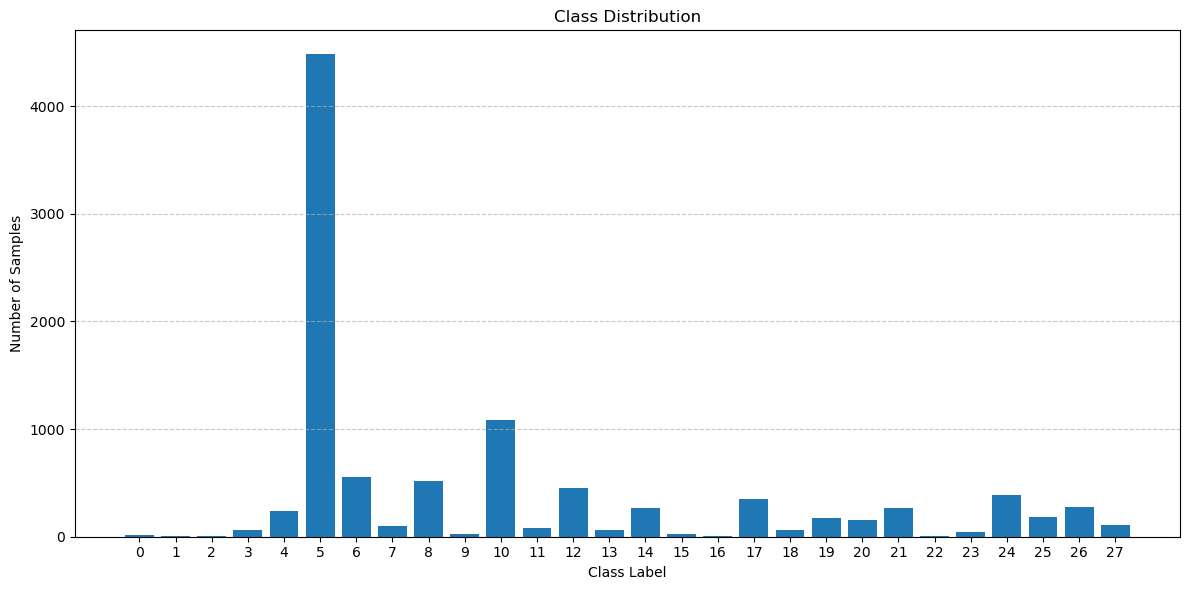

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(class_counts.index) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [112]:
import numpy as np
from sklearn.linear_model import Lasso
def lasso_selection(X, y, alpha=0.01, max_iter=1000):
    X_scaled = StandardScaler().fit_transform(X)

    lasso = Lasso(alpha=alpha, max_iter=max_iter, random_state=42)
    lasso.fit(X_scaled, y)
    selected_features = np.where(np.abs(lasso.coef_) > 0)[0]

    return selected_features


## Logistic Regression permutation Importance + Decision Tree MultiClass classifier with balanced wieghts

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


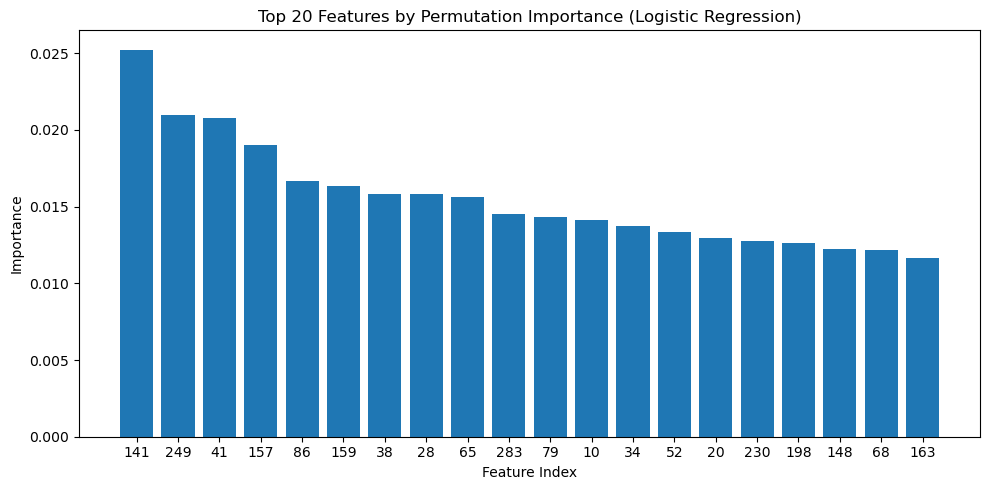

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

X_train_og, X_val_og, y_train_og, y_val_og = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=1000, penalty='l2')
logreg.fit(X_train_og, y_train_og)

result = permutation_importance(logreg, X_val_og, y_val_og, n_repeats=10, scoring='f1_weighted', random_state=42)

sorted_idx = result.importances_mean.argsort()[::-1][:20]
plt.figure(figsize=(10, 5))
plt.bar(range(20), result.importances_mean[sorted_idx])
plt.xticks(range(20), sorted_idx)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Top 20 Features by Permutation Importance (Logistic Regression)")
plt.tight_layout()
plt.show()


In [12]:
X_top20 = X_scaled[:, sorted_idx]
X_test_top20 = X_test_scaled[:, sorted_idx]

In [50]:
def weighted_log_loss(y_true, y_pred, eps=1e-15):
    """
    Compute the weighted cross-entropy (log loss) given true labels and predicted probabilities.
    
    Parameters:
    - y_true: (N, C) One-hot encoded true labels
    - y_pred: (N, C) Predicted probabilities
    
    Returns:
    - Weighted log loss (scalar).
    """

    y_pred = np.clip(y_pred, eps, 1 - eps)
    # Compute class frequencies
    class_counts = np.sum(y_true, axis=0)  # Sum over samples to get counts per class
    class_weights = 1.0 / class_counts
    class_weights /= np.sum(class_weights)  # Normalize weights to sum to 1
    
    # Compute weighted loss
    sample_weights = np.sum(y_true * class_weights, axis=1)  # Get weight for each sample
    loss = -np.mean(sample_weights * np.sum(y_true * np.log(y_pred), axis=1))
    
    return loss

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_top20, y, test_size=0.2, stratify=y, random_state=42)

clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_val)

y_val_oh_dt = np.zeros((y_val.shape[0], len(np.unique(y_train))))
y_val_oh_dt[np.arange(y_val.shape[0]), y_val] = 1


loss = weighted_log_loss(y_val_oh_dt, y_pred_prob)
print(f"Weighted Log Loss: {loss:.4f}")



Weighted Log Loss: 0.0784


## XGboost

In [113]:
selected_features = lasso_selection(X_train_og, y_train_og)
X_train_lasso = X_train_og[:, selected_features]
X_val_lasso = X_val_og[:, selected_features]

In [114]:
print(f"Selected features: {selected_features}, length: {len(selected_features)}")

Selected features: [  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  18  21
  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59  61
  62  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98 101 102
 103 104 105 106 107 109 110 111 113 115 116 117 118 119 120 121 122 123
 124 127 129 130 132 133 134 135 136 138 139 140 143 145 147 149 152 153
 154 155 156 157 160 161 162 163 165 166 167 168 169 170 171 172 174 175
 176 177 178 179 180 181 182 183 184 185 187 188 189 190 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 210 212 213 214 215 217
 218 219 221 222 223 224 225 227 228 229 230 231 232 233 234 235 236 237
 238 239 241 242 243 244 247 249 250 251 252 253 254 257 258 259 260 262
 263 265 266 267 268 269 270 271 272 274 275 276 277 278 279 280 281 283
 284 285 286 287 288 290 292 293

In [15]:
def weighted_log_loss(y_true, y_pred):
    """
    Compute the weighted cross-entropy (log loss) given true labels and predicted probabilities.
    
    Parameters:
    - y_true: (N, C) One-hot encoded true labels
    - y_pred: (N, C) Predicted probabilities
    
    Returns:
    - Weighted log loss (scalar).
    """
    # Compute class frequencies
    class_counts = np.sum(y_true, axis=0)  # Sum over samples to get counts per class
    class_weights = 1.0 / class_counts
    class_weights /= np.sum(class_weights)  # Normalize weights to sum to 1
    
    # Compute weighted loss
    sample_weights = np.sum(y_true * class_weights, axis=1)  # Get weight for each sample
    loss = -np.mean(sample_weights * np.sum(y_true * np.log(y_pred), axis=1))
    
    return loss

In [115]:
# Install required libraries if needed

from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# 3. XGBoost with sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_og)

xgb_lasso = XGBClassifier(objective='multi:softmax',
                    num_class=len(np.unique(y_train_og)),
                    eval_metric='mlogloss',
                    max_depth=3,
                    reg_alpha=2,
                    random_state=42)

xgb_lasso.fit(X_train_lasso, y_train_og, sample_weight=sample_weights)
y_pred_xgb_lasso = xgb_lasso.predict(X_val_lasso)
print("=== XGBoost with Sample Weights ===")
y_pred_proba_xgb_lasso = xgb_lasso.predict_proba(X_val_lasso)
print(classification_report(y_val_og, y_pred_xgb_lasso, digits=3))


y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1


loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_lasso)
print(f"Weighted Log Loss: {loss:.4f}")

=== XGBoost with Sample Weights ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.188     0.231     0.207        13
           4      0.475     0.583     0.523        48
           5      0.923     0.845     0.882       896
           6      0.836     0.919     0.876       111
           7      0.571     0.381     0.457        21
           8      0.681     0.767     0.721       103
           9      0.000     0.000     0.000         5
          10      0.748     0.782     0.765       216
          11      0.375     0.562     0.450        16
          12      0.486     0.560     0.520        91
          13      1.000     0.083     0.154        12
          14      0.080     0.132     0.099        53
          15      0.400     0.400     0.400         5
          16      1.000     1.000     1.000  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
# Install required libraries if needed

from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# 3. XGBoost with sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_og)

xgb = XGBClassifier(objective='multi:softmax',
                    num_class=len(np.unique(y_train_og)),
                    eval_metric='mlogloss',
                    max_depth=3,
                    reg_alpha=2,
                    random_state=42)

xgb.fit(X_train_og, y_train_og, sample_weight=sample_weights)
y_pred_xgb = xgb.predict(X_val_og)
print("=== XGBoost with Sample Weights ===")
y_pred_proba_xgb = xgb.predict_proba(X_val_og)
print(classification_report(y_val_og, y_pred_xgb, digits=3))


y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1


loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb)
print(f"Weighted Log Loss: {loss:.4f}")

=== XGBoost with Sample Weights ===
              precision    recall  f1-score   support

           0      1.000     0.250     0.400         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.364     0.308     0.333        13
           4      0.500     0.583     0.538        48
           5      0.925     0.856     0.889       896
           6      0.835     0.910     0.871       111
           7      0.471     0.381     0.421        21
           8      0.650     0.738     0.691       103
           9      0.000     0.000     0.000         5
          10      0.752     0.801     0.776       216
          11      0.455     0.625     0.526        16
          12      0.476     0.538     0.505        91
          13      0.000     0.000     0.000        12
          14      0.090     0.132     0.107        53
          15      0.400     0.400     0.400         5
          16      0.500     1.000     0.667  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
# Install required libraries if needed
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # <--- to combine them easily

# 1. Create SMOTE + RandomUnderSampler pipeline
over = SMOTE(random_state=42, k_neighbors=1)
under = RandomUnderSampler(random_state=42)

# Combine them
resample_pipeline = Pipeline([
    ('o', over),
    ('u', under)
])

# 2. Apply SMOTE + RandomUnderSampler
X_train_balanced, y_train_balanced = resample_pipeline.fit_resample(X_train_og, y_train_og)

# 3. Compute sample weights after resampling
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_balanced)

# 4. Train XGB_1oost
xgb_1 = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_balanced)),  # important: based on new labels
    eval_metric='mlogloss',
    max_depth=3,
    reg_alpha=2,
    random_state=42
)

xgb_1.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

# 5. Predict
y_pred_xgb_1 = xgb_1.predict(X_val_og)
y_pred_proba_xgb_1 = xgb_1.predict_proba(X_val_og)

# 6. Evaluation
print("=== XGB_1oost with SMOTE + Random Undersampling ===")
print(classification_report(y_val_og, y_pred_xgb_1, digits=3))

# 7. Weighted Log Loss calculation
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_balanced))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_1)
print(f"Weighted Log Loss: {loss:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:27:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGB_1oost with SMOTE + Random Undersampling ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.308     0.308     0.308        13
           4      0.545     0.625     0.583        48
           5      0.899     0.898     0.899       896
           6      0.887     0.919     0.903       111
           7      0.600     0.429     0.500        21
           8      0.691     0.738     0.714       103
           9      0.000     0.000     0.000         5
          10      0.803     0.829     0.815       216
          11      0.625     0.625     0.625        16
          12      0.500     0.549     0.524        91
          13      0.167     0.083     0.111        12
          14      0.049     0.057     0.053        53
          15      0.600     0.600     0.600         5
          16      1.000     1

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
def weighted_log_loss_scorer(estimator, X, y):
    # estimator is the model (XGBClassifier)
    # X is the validation data
    # y is the true labels

    y_pred_proba = estimator.predict_proba(X)

    # One-hot encode y_true manually
    y_val_oh = np.zeros((y.shape[0], y_pred_proba.shape[1]))
    y_val_oh[np.arange(y.shape[0]), y] = 1

    loss = weighted_log_loss(y_val_oh, y_pred_proba)

    return -loss  # flip sign because lower loss = better

In [57]:
# Install required libraries if needed
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import make_scorer

scorer = make_scorer(weighted_log_loss, greater_is_better=False)

# 1. Compute sample weights (before tuning)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_og)

# 2. Define parameter grid for tuning
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800]
}

# 3. Set up XGBClassifier base model
xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train_og)),
    eval_metric='mlogloss',
    random_state=42
)

# 4. Randomized Search for Hyperparameter Tuning
random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,  # Try 30 random combinations
    scoring=weighted_log_loss_scorer, 
    cv=3,
    random_state=42,
    n_jobs=-1,
)

# 5. Fit RandomizedSearchCV
random_search.fit(X_train_og, y_train_og, sample_weight=sample_weights)

# 6. Retrieve the best model
best_xgb = random_search.best_estimator_

print("\nBest Hyperparameters:", random_search.best_params_)

# 7. Predict and Evaluate
y_pred_xgb_hpt = best_xgb.predict(X_val_og)
y_pred_proba_xgb_hpt = best_xgb.predict_proba(X_val_og)

print("\n=== XGBoost with Tuned Hyperparameters ===")
print(classification_report(y_val_og, y_pred_xgb_hpt, digits=3))

# 8. Calculate Weighted Log Loss
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_hpt)
print(f"Weighted Log Loss: {loss:.4f}")



Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 2, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}

=== XGBoost with Tuned Hyperparameters ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.400     0.308     0.348        13
           4      0.537     0.604     0.569        48
           5      0.938     0.834     0.883       896
           6      0.841     0.955     0.895       111
           7      0.600     0.429     0.500        21
           8      0.652     0.728     0.688       103
           9      0.000     0.000     0.000         5
          10      0.786     0.801     0.794       216
          11      0.458     0.688     0.550        16
          12      0.534     0.604     0.567        91
    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# 1. Compute Improved Sample Weights
classes = np.unique(y_train_og)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_og)
class_weight_dict = dict(zip(classes, class_weights_array))
sample_weights = np.array([class_weight_dict[label] for label in y_train_og])

# 2. Define Parameter Grid for Randomized Search
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [5, 10, 15],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800]
}

# 3. Create base XGBClassifier
xgb_base_1 = XGBClassifier(
    objective='multi:softprob',  # <-- softprob for probability outputs
    num_class=len(classes),
    eval_metric='mlogloss',
    random_state=42
)

# 4. RandomizedSearchCV Setup
random_search_1 = RandomizedSearchCV(
    xgb_base_1,
    param_distributions=param_dist,
    n_iter=30,  # Try 30 random combinations
    scoring=weighted_log_loss_scorer,  # Use negative log loss directly
    cv=3,
    random_state=42,
    n_jobs=-1
)

# 5. Fit RandomizedSearchCV
random_search_1.fit(X_train_og, y_train_og, sample_weight=sample_weights)

# 6. Retrieve best model
xgb_best = random_search_1.best_estimator_

print("\nBest Hyperparameters:", random_search_1.best_params_)

# 7. Predict with Best Model
y_pred_proba_xgb_best_1 = xgb_best.predict_proba(X_val_og)
y_pred_xgb = np.argmax(y_pred_proba_xgb_best_1, axis=1)

# 8. Evaluation
print("\n=== Tuned XGBoost with Improved Sample Weights ===")
print(classification_report(y_val_og, y_pred_xgb, digits=3))

# 9. Custom Weighted Log Loss Calculation
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_best_1)
print(f"Weighted Log Loss: {loss:.4f}")



Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 2, 'n_estimators': 500, 'min_child_weight': 15, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}

=== Tuned XGBoost with Improved Sample Weights ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.357     0.385     0.370        13
           4      0.537     0.604     0.569        48
           5      0.940     0.857     0.897       896
           6      0.837     0.928     0.880       111
           7      0.562     0.429     0.486        21
           8      0.681     0.786     0.730       103
           9      0.000     0.000     0.000         5
          10      0.791     0.824     0.807       216
          11      0.500     0.750     0.600        16
          12      0.559     0.571     0.565      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [116]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# 1. Compute Improved Sample Weights
classes = np.unique(y_train_og)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_og)
class_weight_dict = dict(zip(classes, class_weights_array))
sample_weights = np.array([class_weight_dict[label] for label in y_train_og])

# 2. Define Parameter Grid for Randomized Search
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [5, 10, 15],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800]
}

# 3. Create base XGBClassifier
xgb_base_2 = XGBClassifier(
    objective='multi:softprob',  # <-- softprob for probability outputs
    num_class=len(classes),
    eval_metric='mlogloss',
    random_state=42
)

# 4. RandomizedSearchCV Setup
random_search_2 = RandomizedSearchCV(
    xgb_base_2,
    param_distributions=param_dist,
    n_iter=30,  # Try 30 random combinations
    scoring=weighted_log_loss_scorer,  # Use negative log loss directly
    cv=3,
    random_state=42,
    n_jobs=-1
)

# 5. Fit RandomizedSearchCV
random_search_2.fit(X_train_lasso, y_train_og, sample_weight=sample_weights)

# 6. Retrieve best model
xgb_best = random_search_2.best_estimator_

print("\nBest Hyperparameters:", random_search_2.best_params_)

# 7. Predict with Best Model
y_pred_proba_xgb_best_2 = xgb_best.predict_proba(X_val_lasso)
y_pred_xgb = np.argmax(y_pred_proba_xgb_best_2, axis=1)

# 8. Evaluation
print("\n=== Tuned XGBoost with Improved Sample Weights ===")
print(classification_report(y_val_og, y_pred_xgb, digits=3))

# 9. Custom Weighted Log Loss Calculation
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_best_2)
print(f"Weighted Log Loss: {loss:.4f}")



Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}

=== Tuned XGBoost with Improved Sample Weights ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.400     0.462     0.429        13
           4      0.492     0.604     0.542        48
           5      0.935     0.842     0.886       896
           6      0.839     0.937     0.885       111
           7      0.500     0.429     0.462        21
           8      0.634     0.757     0.690       103
           9      0.000     0.000     0.000         5
          10      0.794     0.769     0.781       216
          11      0.480     0.750     0.585        16
          12      0.559     0.571     0.565    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


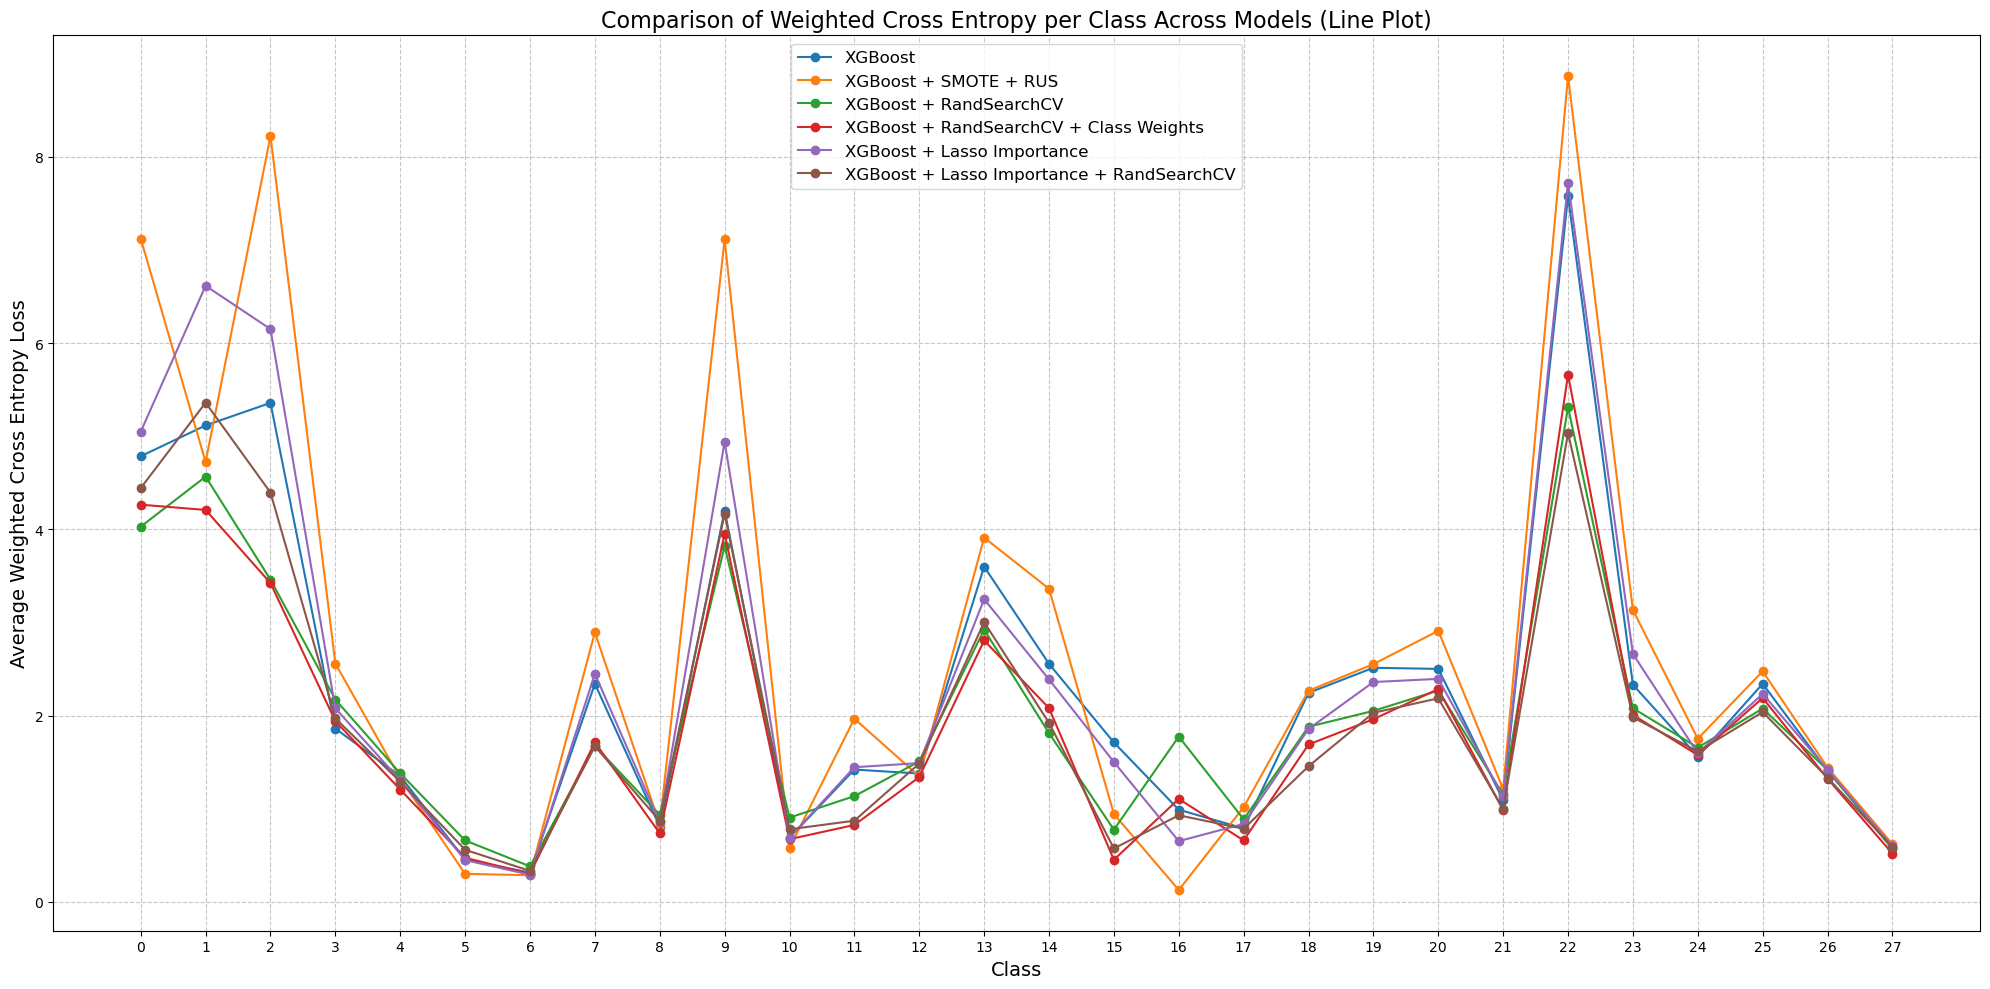

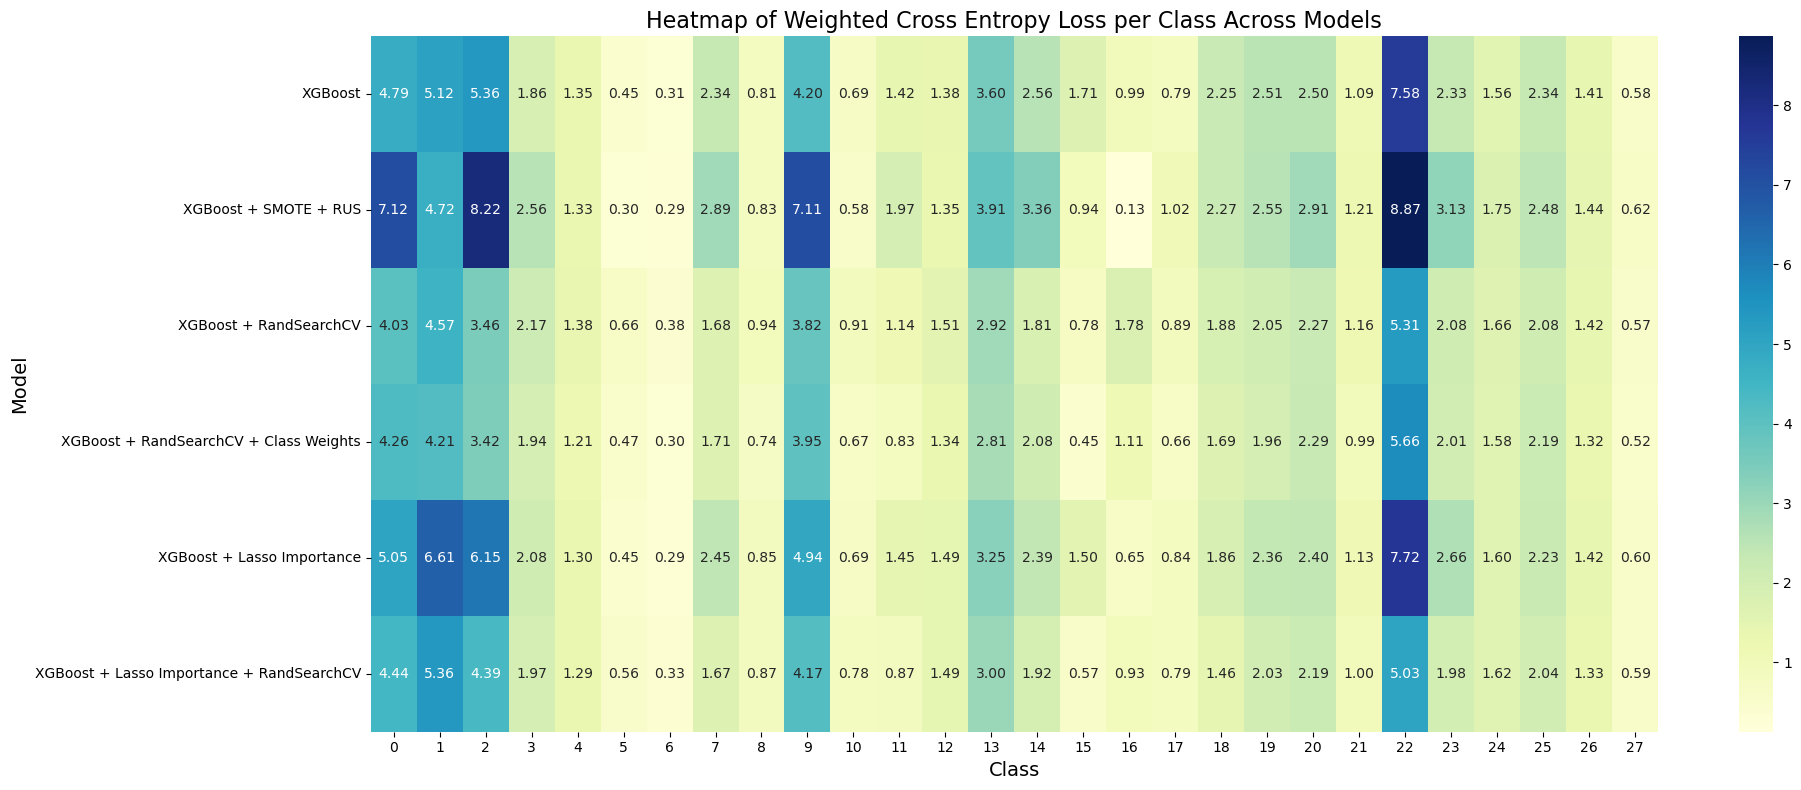

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your compute_class_loss function (same as before)
def compute_class_loss(y_true_oh, y_pred_prob):
    eps = 1e-15
    y_pred_prob_clipped = np.clip(y_pred_prob, eps, 1 - eps)
    sample_losses = -np.sum(y_true_oh * np.log(y_pred_prob_clipped), axis=1)
    true_classes = np.argmax(y_true_oh, axis=1)
    
    losses_by_class = {}
    for c in np.unique(true_classes):
        losses_by_class[c] = sample_losses[true_classes == c]
    
    avg_loss_per_class = {c: np.mean(losses) for c, losses in losses_by_class.items()}
    return avg_loss_per_class

# ====== Your Models Dictionary ======

models = {
    'XGBoost': y_pred_proba_xgb,
    'XGBoost + SMOTE + RUS': y_pred_proba_xgb_1,
    'XGBoost + RandSearchCV': y_pred_proba_xgb_hpt,
    'XGBoost + RandSearchCV + Class Weights': y_pred_proba_xgb_best_1,
    'XGBoost + Lasso Importance': y_pred_proba_xgb_lasso,
    'XGBoost + Lasso Importance + RandSearchCV': y_pred_proba_xgb_best_2,
    # Add more models if needed
}

# ====== Calculate Per-Class Losses for Each Model ======

loss_per_class_all_models = {}

for model_name, probs in models.items():
    loss_per_class = compute_class_loss(y_val_oh, probs)
    loss_per_class_all_models[model_name] = loss_per_class

# Classes
classes = sorted(list(loss_per_class_all_models['XGBoost'].keys()))

# ====== LINE PLOT VERSION ======

plt.figure(figsize=(20,10))

for model_name, class_losses in loss_per_class_all_models.items():
    losses = [class_losses[c] for c in classes]
    plt.plot(classes, losses, marker='o', label=model_name)

plt.xlabel('Class', fontsize=14)
plt.ylabel('Average Weighted Cross Entropy Loss', fontsize=14)
plt.title('Comparison of Weighted Cross Entropy per Class Across Models (Line Plot)', fontsize=16)
plt.xticks(classes)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ====== HEATMAP VERSION ======

# Build a matrix: rows = models, columns = classes
loss_matrix = []
model_names = []

for model_name, class_losses in loss_per_class_all_models.items():
    losses = [class_losses[c] for c in classes]
    loss_matrix.append(losses)
    model_names.append(model_name)

loss_matrix = np.array(loss_matrix)

plt.figure(figsize=(20,8))

sns.heatmap(loss_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=classes, yticklabels=model_names)

plt.xlabel('Class', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Heatmap of Weighted Cross Entropy Loss per Class Across Models', fontsize=16)
plt.tight_layout()
plt.show()


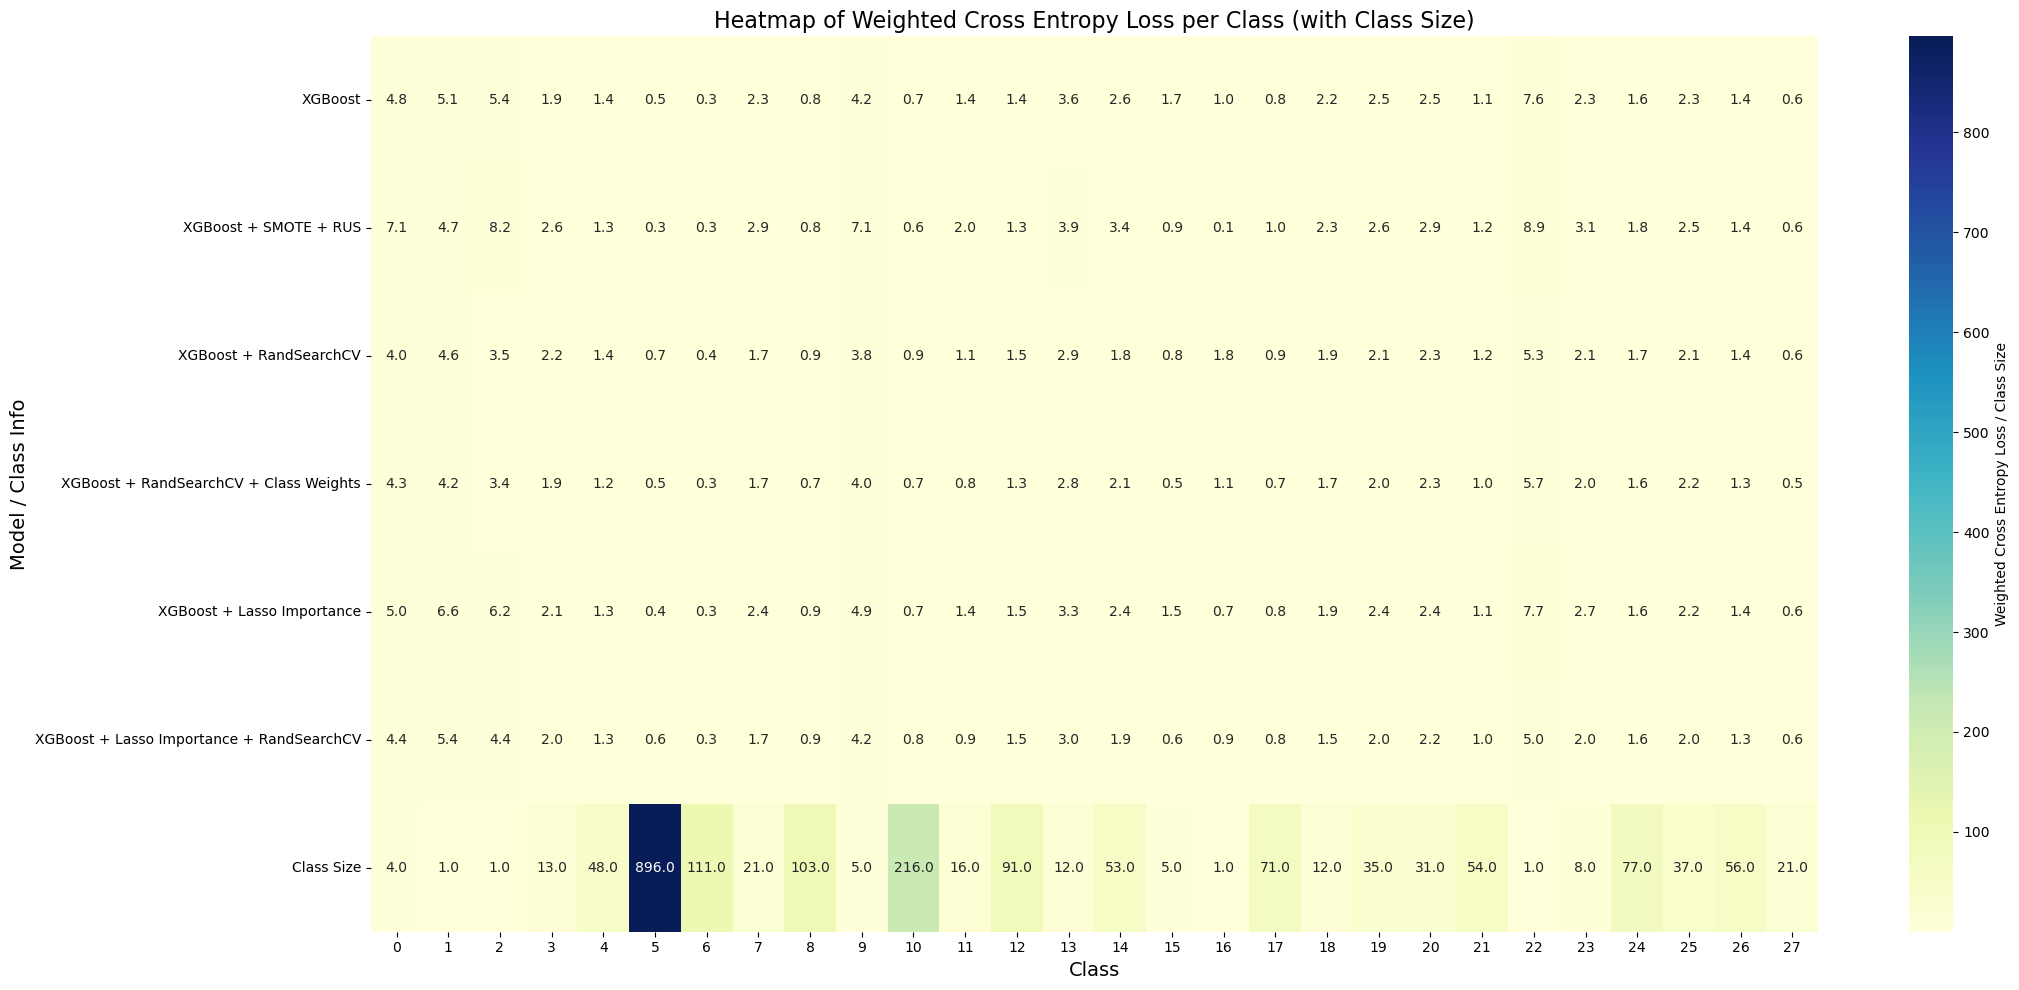


Correlation between Class Size and Average Weighted Cross Entropy Loss: -0.337


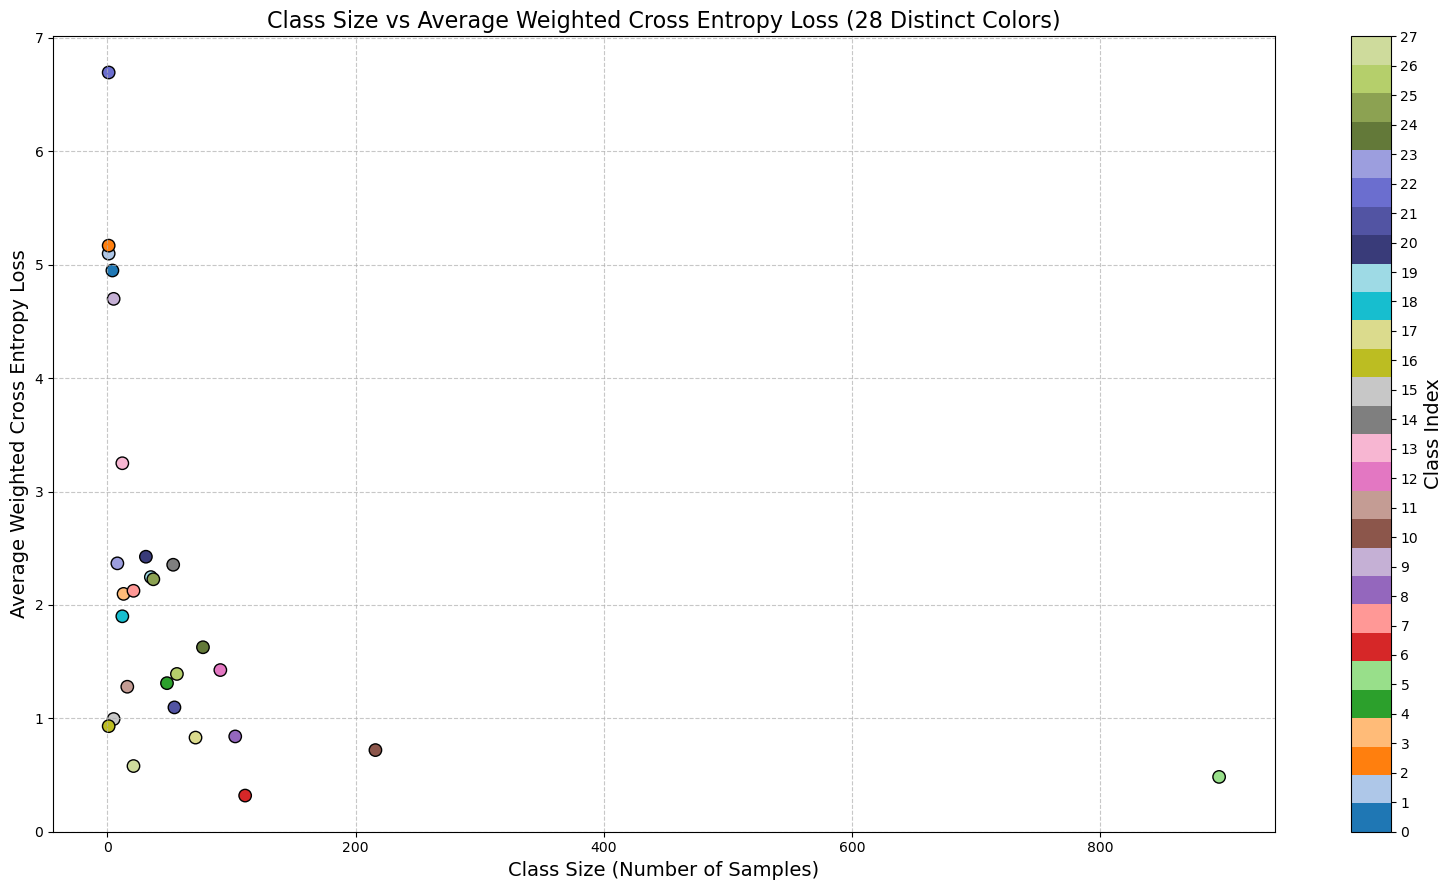

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ====== Function to Compute Per-Class Loss ======

def compute_class_loss(y_true_oh, y_pred_prob):
    eps = 1e-15
    y_pred_prob_clipped = np.clip(y_pred_prob, eps, 1 - eps)
    sample_losses = -np.sum(y_true_oh * np.log(y_pred_prob_clipped), axis=1)
    true_classes = np.argmax(y_true_oh, axis=1)
    
    losses_by_class = {}
    for c in np.unique(true_classes):
        losses_by_class[c] = sample_losses[true_classes == c]
    
    avg_loss_per_class = {c: np.mean(losses) for c, losses in losses_by_class.items()}
    return avg_loss_per_class

# ====== Your Models' Predicted Probabilities ======

models = {
    'XGBoost': y_pred_proba_xgb,
    'XGBoost + SMOTE + RUS': y_pred_proba_xgb_1,
    'XGBoost + RandSearchCV': y_pred_proba_xgb_hpt,
    'XGBoost + RandSearchCV + Class Weights': y_pred_proba_xgb_best_1,
    'XGBoost + Lasso Importance': y_pred_proba_xgb_lasso,
    'XGBoost + Lasso Importance + RandSearchCV': y_pred_proba_xgb_best_2,
    # Add more models if needed
}

# ====== Calculate Per-Class Loss for Each Model ======

loss_per_class_all_models = {}

for model_name, probs in models.items():
    loss_per_class = compute_class_loss(y_val_oh, probs)
    loss_per_class_all_models[model_name] = loss_per_class

# ====== Prepare Loss Matrix ======

classes = sorted(list(loss_per_class_all_models['XGBoost'].keys()))
x = np.arange(len(classes))

loss_matrix = []
model_names = []

for model_name, class_losses in loss_per_class_all_models.items():
    losses = [class_losses[c] for c in classes]
    loss_matrix.append(losses)
    model_names.append(model_name)

loss_matrix = np.array(loss_matrix)

# ====== Compute Class Sizes ======

# Assuming y_val_og is your validation labels
class_counts = np.bincount(y_val_og)

# Add Class Size as an extra row
loss_matrix_with_size = np.vstack([loss_matrix, class_counts[classes]])
model_names_with_size = model_names + ['Class Size']

# ====== Plot Heatmap ======

plt.figure(figsize=(22,10))

sns.heatmap(loss_matrix_with_size, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=classes, yticklabels=model_names_with_size,
            cbar_kws={'label': 'Weighted Cross Entropy Loss / Class Size'})

plt.xlabel('Class', fontsize=14)
plt.ylabel('Model / Class Info', fontsize=14)
plt.title('Heatmap of Weighted Cross Entropy Loss per Class (with Class Size)', fontsize=16)
plt.tight_layout()
plt.show()

# ====== Correlation Between Class Size and Average Loss ======

# Average loss across models for each class (not including class size row)
avg_loss_per_class = np.mean(loss_matrix, axis=0)

correlation = np.corrcoef(class_counts[classes], avg_loss_per_class)[0,1]
print(f"\nCorrelation between Class Size and Average Weighted Cross Entropy Loss: {correlation:.3f}")

# ====== Scatter Plot Class Size vs Average Loss (Optional) ======

num_classes = len(classes)  # 28 classes

# Build a set of distinct colors manually
# Combine from several good Matplotlib palettes
colors = (plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors)[:28]
# tab20 (20 colors) + tab20b (20) + tab20c (20) --> safely get 28 distinct

# Create a ListedColormap
new_cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(16,9))

scatter = plt.scatter(class_counts[classes], avg_loss_per_class, 
                      c=classes, cmap=new_cmap, s=80, edgecolor='k')

# Create discrete colorbar
cbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
cbar.set_label('Class Index', fontsize=14)
cbar.set_ticks(np.arange(num_classes))
cbar.set_ticklabels(classes)

plt.xlabel('Class Size (Number of Samples)', fontsize=14)
plt.ylabel('Average Weighted Cross Entropy Loss', fontsize=14)
plt.title('Class Size vs Average Weighted Cross Entropy Loss (28 Distinct Colors)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()






In [20]:
y_pred_xgb_real = xgb.predict(X_test1)
print("=== XGBoost with Sample Weights on Text ===")
print(y_pred_xgb_real)

=== XGBoost with Sample Weights on Text ===
[ 5  5 10 17 12  7  5  5  6 26 10 27  5  5  5  0  8 10  5 17 24  5 24  5
  5  5 12 10  5  5 26  5  5 17  5 14  5  8 10  5 20 17 10 10 24 10  5  5
 12 10 10  5 20  5  5  8  6  5  8  5 17  5 14  5  6  5  6 17  8 10 12  5
 13 25  5 17 14  5  5 17  5  5  5 20  5 17  5 24  5 17  5  5  5 10  5 12
  5 12  3 10 14  5 25  5  8  5 19  5 10 10  5 21  5 24 17 12 12  5  8  5
  5 25  5  5 24  5  5 10 10 21  4  5  4 24 24 27 20  6 12  5 17  5 11  3
  5  4 19  5 10 20  7  5  6 12 12 26 21  5 10 23  5 12  5  5  5  5  5  5
  8 12 10  5 12  7  8 15  5  5 24  8  5  6 17  5  4 19  8 24  5 12  5  7
 12  5  5  8 25 12  5 24  4  5 27 10  5  5  5  5  8  5 10  3  5  5 12  5
 10  8 12  5  5 27  5  6 17 12  5  8  5 24 21  6 10  8  5 12  5 10  5 25
  5  4 25 10 12 24 10  8 21 26 10  7 12 10 12 12 10  5  5 26  6 10  5  5
 27  8  5  8 11 26  5  8 10  6  5  6  8 10 10  5 25  7  5 26  5  8  5 26
  5 24  5  5  5  5 21  5 10 12  5  5  5 25 27  6  5  5 24 26 10 12 18 24
  5 17 